In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=46f961dc2ba096bd384b1711a5ad17dfd4c89bf03eba809ae1c67287152485d8
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Wejo JSON RDD Example") \
    .getOrCreate()


from google.colab import files

# Prompt to upload the file
uploaded = files.upload()

In [5]:
import pandas as pd

# Read the CSV file, skipping the initial unnecessary rows
file_path = '/content/apple_stock.csv'

# Read the CSV file, handling potential errors
df = pd.read_csv(file_path, on_bad_lines='skip') # skip lines with errors

In [6]:
# Step 1: Create Spark Session
spark = SparkSession.builder.appName("AppleStockAnalysis").getOrCreate()

# Step 2: Load CSV file into PySpark DataFrame
df_spark = spark.read.csv("/content/apple_stock.csv", header=True, inferSchema=True)

# Step 3: Show the first 20 rows
df_spark.show(20)

+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|212.79999700000002|        213.000002|      

In [7]:
# Step 4: Print the schema of the DataFrame
df_spark.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



In [8]:
# Step 5: Get the number of rows
row_count = df_spark.count()
print(f"Number of rows: {row_count}")


Number of rows: 1762


In [9]:
# Step 6: Perform basic descriptive statistics
df_spark.describe().show()


+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|summary|              Open|              High|               Low|            Close|             Volume|         Adj Close|
+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|  count|              1762|              1762|              1762|             1762|               1762|              1762|
|   mean| 313.0763111589103| 315.9112880164581| 309.8282405079457|312.9270656379113|9.422577587968218E7| 75.00174115607275|
| stddev|185.29946803981522|186.89817686485767|183.38391664371008|185.1471036170943|6.020518776592709E7| 28.57492972179906|
|    min|              90.0|         90.699997|         89.470001|        90.279999|           11475900|         24.881912|
|    max|        702.409988|        705.070023|        699.569977|       702.100021|          470249500|127.96609099999999|
+-------

In [10]:
from pyspark.sql.functions import col, round

# Select key columns: ("Date", "Open", "Close", "Volume")
selected_df = df_spark.select("Date", "Open", "Close", "Volume")

# Step 7: Calculate Daily Price Change (Close - Open)
selected_df = selected_df.withColumn("Daily_Price_Change", round(col("Close") - col("Open"), 2))

# Step 8: Calculate Average Daily Volume
average_volume = selected_df.select("Volume").groupBy().avg("Volume").collect()[0][0]
print(f"Average Daily Volume: {average_volume}")

# Step 9: Find Maximum and Minimum Closing Prices
max_close = selected_df.agg({"Close": "max"}).collect()[0][0]
min_close = selected_df.agg({"Close": "min"}).collect()[0][0]
print(f"Maximum Closing Price: {max_close}")
print(f"Minimum Closing Price: {min_close}")

# Display results
selected_df.show(5)


Average Daily Volume: 94225775.87968218
Maximum Closing Price: 702.100021
Minimum Closing Price: 90.279999
+----------+----------+------------------+---------+------------------+
|      Date|      Open|             Close|   Volume|Daily_Price_Change|
+----------+----------+------------------+---------+------------------+
|2010-01-04|213.429998|        214.009998|123432400|              0.58|
|2010-01-05|214.599998|        214.379993|150476200|             -0.22|
|2010-01-06|214.379993|        210.969995|138040000|             -3.41|
|2010-01-07|    211.75|            210.58|119282800|             -1.17|
|2010-01-08|210.299994|211.98000499999998|111902700|              1.68|
+----------+----------+------------------+---------+------------------+
only showing top 5 rows



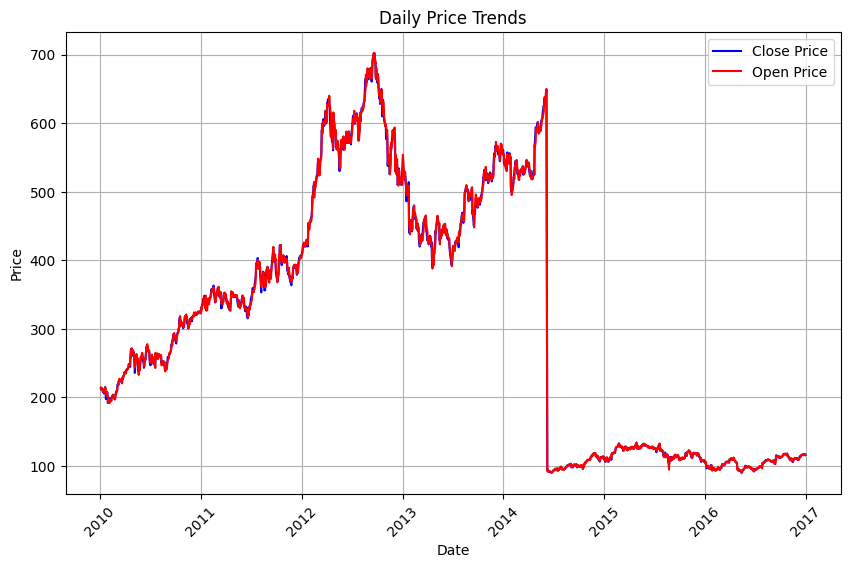

In [11]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
pandas_df = selected_df.toPandas()

# Convert 'Date' to datetime
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

# Plot the daily price trends
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['Date'], pandas_df['Close'], label='Close Price', color='b')
plt.plot(pandas_df['Date'], pandas_df['Open'], label='Open Price', color='r')

plt.title('Daily Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


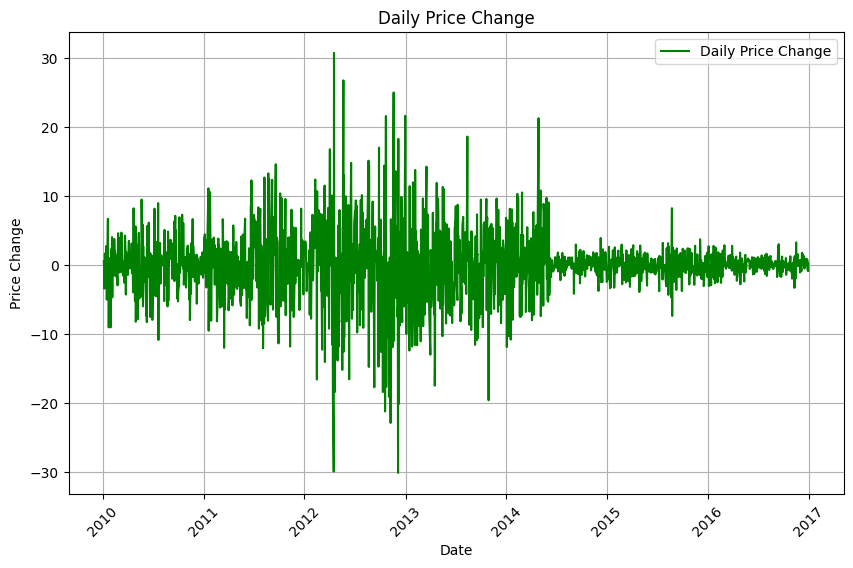

In [12]:
# Re-load the CSV file, calculate Daily Price Change, and plot the results

# Load CSV file into pandas DataFrame first
df = pd.read_csv(file_path, on_bad_lines='skip')

# Calculate Daily Price Change
df['Daily_Price_Change'] = df['Close'] - df['Open']

# Convert 'Date' to datetime for better plotting
df['Date'] = pd.to_datetime(df['Date'])

# Plot the daily price change
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Daily_Price_Change'], label='Daily Price Change', color='g')

plt.title('Daily Price Change')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


1. How to Filter Data for Specific Months or Years:

You can filter the data by using Pandas’ dt accessor, which allows you to easily extract components of the Date column, such as year or month.

2. Identify the Highest Daily Price Increase:

To identify the highest daily price increase, you can use Pandas' idxmax() function to find the index of the row where the Daily_Price_Change is maximum.

In [13]:
# Find the row with the highest daily price increase
max_increase_row = df.loc[df['Daily_Price_Change'].idxmax()]

# Show the details of the highest increase
print(f"Date of highest price increase: {max_increase_row['Date']}")
print(f"Highest daily price increase: {max_increase_row['Daily_Price_Change']}")
print(f"Open price: {max_increase_row['Open']}")
print(f"Close price: {max_increase_row['Close']}")


Date of highest price increase: 2012-04-17 00:00:00
Highest daily price increase: 30.760008999999968
Open price: 578.93998
Close price: 609.699989


In [15]:
# Step 1: Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Step 2: Initialize Spark session
spark = SparkSession.builder.appName("ID_31_Data_Analysis").getOrCreate()

# Step 3: Download the file (since we cannot download directly, ensure you upload 'ID_31_data.csv' in Colab)

# Step 4: Load the CSV file using PySpark
file_path = '/content/ID_31_data.csv'

# Load CSV file into PySpark DataFrame
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the loaded data
df_spark.show(5)


+-------------------+---------+----------+-----------+-------+--------+---+----+--------+--------------+-----------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-----------+----------+----+----------+-------------------+-------------------+-------------------+-------+-------+-------+-----------+----------+---------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+---------------+-----------+----------+---------+--------------------+--------+-----------------+
|  capturedtimestamp| latitude| longitude|      speed|geohash|   month|day|hour|      ID|Custom_ID_left|index_right|Custom_ID_right|FIRST_ROUT_1|FIRST_ROAD_1|FIRST_MEDI_1|FIRST_AADT_1|FIRST_NUMB_1| MEAN_AADT_1|MEAN_EXPAN_1|MEAN_PERCE_1|MEAN_MEDIA_1| MEAN_SURFA_1|BUFF_DIST_1|ORIG_FID_1|freq|      date|             Time26|         date_time1|          

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, TimestampType

# Step 1: Ensure 'speed' is of type Double and 'ID' is Integer
df_spark = df_spark.withColumn("speed", df_spark["speed"].cast(DoubleType()))
df_spark = df_spark.withColumn("ID", df_spark["ID"].cast(IntegerType()))

# Step 2: Convert 'capturedtimestamp' to Spark timestamp type
df_spark = df_spark.withColumn("capturedtimestamp", F.to_timestamp(df_spark["capturedtimestamp"]))

# Step 3: Extract hour and day of the week for further analysis
df_spark = df_spark.withColumn("hour", F.hour(df_spark["capturedtimestamp"]))
df_spark = df_spark.withColumn("day_of_week", F.dayofweek(df_spark["capturedtimestamp"]))

# Step 4: Compute the required statistics using PySpark functions

# Define the speed limits for the calculations
speed_limit = 50.0  # Assuming a general speed limit for demonstration

# Fraction of records where speed is over the limit by 5, 10, and 20
df_spark = df_spark.withColumn("over_5_limit", F.when(df_spark["speed"] > (speed_limit + 5), 1).otherwise(0))
df_spark = df_spark.withColumn("over_10_limit", F.when(df_spark["speed"] > (speed_limit + 10), 1).otherwise(0))
df_spark = df_spark.withColumn("over_20_limit", F.when(df_spark["speed"] > (speed_limit + 20), 1).otherwise(0))

# Calculate fractions
total_records = df_spark.count()
fraction_5_over_limit = df_spark.groupBy().sum("over_5_limit").first()[0] / total_records
fraction_10_over_limit = df_spark.groupBy().sum("over_10_limit").first()[0] / total_records
fraction_20_over_limit = df_spark.groupBy().sum("over_20_limit").first()[0] / total_records

# Output results
print(f"Fraction of records over 5 over limit: {fraction_5_over_limit}")
print(f"Fraction of records over 10 over limit: {fraction_10_over_limit}")
print(f"Fraction of records over 20 over limit: {fraction_20_over_limit}")


Fraction of records over 5 over limit: 0.5706776180698152
Fraction of records over 10 over limit: 0.26625990026400703
Fraction of records over 20 over limit: 0.0


+----+------------+
|  ID|median_speed|
+----+------------+
|NULL|   56.544761|
+----+------------+

Fraction of records over 5 over limit: 0.5706776180698152
Fraction of records over 10 over limit: 0.26625990026400703
Fraction of records over 20 over limit: 0.0
Median speeds per journey: 
+----+------------+
|  ID|median_speed|
+----+------------+
|NULL|   56.544761|
+----+------------+



/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


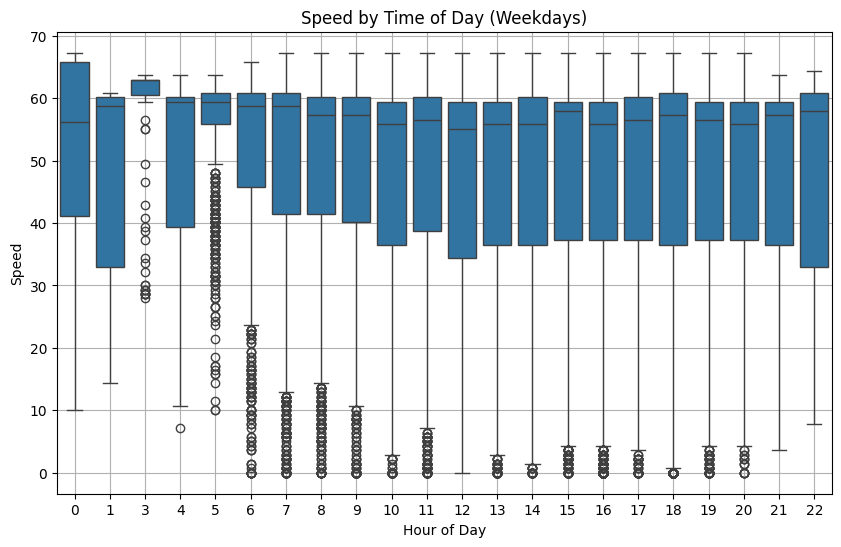

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


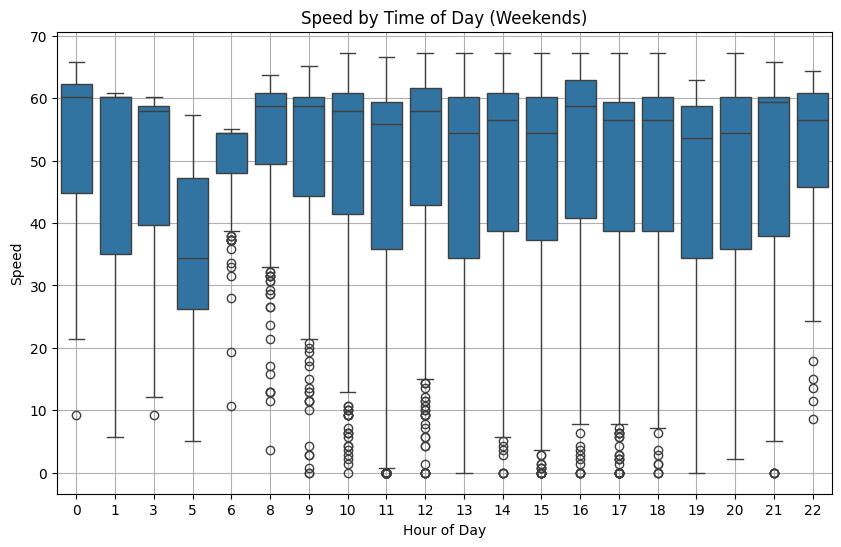

In [17]:
import logging
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initialize basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("SpeedAnalysisLogger")

# Ensure 'speed' is Double and 'ID' is Integer
df_spark = df_spark.withColumn("speed", df_spark["speed"].cast(DoubleType()))
df_spark = df_spark.withColumn("ID", df_spark["ID"].cast(IntegerType()))

# Convert timestamp to Spark timestamp type
df_spark = df_spark.withColumn("capturedtimestamp", F.to_timestamp(df_spark["capturedtimestamp"]))

# Extract hour and day of the week
df_spark = df_spark.withColumn("hour", F.hour(df_spark["capturedtimestamp"]))
df_spark = df_spark.withColumn("day_of_week", F.dayofweek(df_spark["capturedtimestamp"]))

# Define speed limit and calculate statistics for speed over limits
speed_limit = 50.0

df_spark = df_spark.withColumn("over_5_limit", F.when(df_spark["speed"] > (speed_limit + 5), 1).otherwise(0))
df_spark = df_spark.withColumn("over_10_limit", F.when(df_spark["speed"] > (speed_limit + 10), 1).otherwise(0))
df_spark = df_spark.withColumn("over_20_limit", F.when(df_spark["speed"] > (speed_limit + 20), 1).otherwise(0))

# Step 2: Calculate fractions
total_records = df_spark.count()
fraction_5_over_limit = df_spark.groupBy().sum("over_5_limit").first()[0] / total_records
fraction_10_over_limit = df_spark.groupBy().sum("over_10_limit").first()[0] / total_records
fraction_20_over_limit = df_spark.groupBy().sum("over_20_limit").first()[0] / total_records

# Log statistics
logger.info(f"Fraction of records over 5 over limit: {fraction_5_over_limit}")
logger.info(f"Fraction of records over 10 over limit: {fraction_10_over_limit}")
logger.info(f"Fraction of records over 20 over limit: {fraction_20_over_limit}")

# Step 3: Calculate the 50th percentile (median) speed per journey
median_speeds = df_spark.groupBy("ID").agg(F.expr('percentile_approx(speed, 0.5)').alias('median_speed'))
median_speeds.show()

# Step 4: Print all statistics
print(f"Fraction of records over 5 over limit: {fraction_5_over_limit}")
print(f"Fraction of records over 10 over limit: {fraction_10_over_limit}")
print(f"Fraction of records over 20 over limit: {fraction_20_over_limit}")
print(f"Median speeds per journey: ")
median_speeds.show()

# Step 5: Convert to Pandas DataFrame for plotting
df_pandas = df_spark.toPandas()

# Step 6: Boxplots for Speed by Time of Day for Weekdays (day_of_week 2 to 6)
weekday_data = df_pandas[(df_pandas['day_of_week'] >= 2) & (df_pandas['day_of_week'] <= 6)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='speed', data=weekday_data)
plt.title('Speed by Time of Day (Weekdays)')
plt.xlabel('Hour of Day')
plt.ylabel('Speed')
plt.grid(True)
plt.show()

# Step 7: Boxplots for Speed by Time of Day for Weekends (day_of_week 1 or 7)
weekend_data = df_pandas[(df_pandas['day_of_week'] == 1) | (df_pandas['day_of_week'] == 7)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='speed', data=weekend_data)
plt.title('Speed by Time of Day (Weekends)')
plt.xlabel('Hour of Day')
plt.ylabel('Speed')
plt.grid(True)
plt.show()
